In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['axes.unicode_minus'] = False


dfw = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv', index_col=0)
dfw.head()

#실습에 사용할 열만 추출
dfw = dfw.filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

#결측치 삽입
from numpy.random import randint
dfm = dfw.copy()

for col in ['Alcohol', 'Ash']:
    rand_idx = randint(0, len(dfm), 25)
    dfm.loc[rand_idx, col] = np.nan

In [5]:
# -------------------------
# Constant Imputation
# -------------------------
dfm_imp = dfm.fillna(1000)

# -------------------------
# 대표값 Imputation
# -------------------------
from sklearn.impute import SimpleImputer

sImp = SimpleImputer(missing_values=np.nan, strategy='mean')
dfm_imp1 = sImp.fit_transform(dfm)
dfm_imp1 = pd.DataFrame(dfm_imp1, columns=dfm.columns)

print(sImp.statistics_)
dfm_imp1

[13.05910256  2.33634831  2.36701299 99.74157303  0.95744944]


,Alcohol,Malicacid,Ash,Magnesium,Hue
0,14.23,1.71,2.430000,127.0,1.04
1,13.20,1.78,2.367013,100.0,1.05
2,13.16,2.36,2.670000,101.0,1.03
3,14.37,1.95,2.500000,113.0,0.86
4,13.24,2.59,2.870000,118.0,1.04
...,...,...,...,...,...
173,13.71,5.65,2.450000,95.0,0.64
174,13.40,3.91,2.480000,102.0,0.70
175,13.27,4.28,2.260000,120.0,0.59
176,13.17,2.59,2.370000,120.0,0.60


In [6]:
# -------------------------
# 단순확률 대치법
# -------------------------
dfm_imp2 = dfm.copy()

for col in ['Alcohol', 'Ash']:
    miss_idx = dfm[dfm[col].isna()==True].index
    dfm_imp2.loc[miss_idx, col] = df[col].sample(len(miss_idx)).values

dfm_imp2.info()

NameError: name 'df' is not defined

In [ ]:
# -------------------------
# 다른 변수들로 모델링하여 결측값을 예측
# -------------------------
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
dfm_imp3 = imputer.fit_transform(dfm)
dfm_imp3 = pd.DataFrame(dfm_imp3, columns=dfm.columns)
dfm_imp3.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

In [ ]:
# -------------------------
# 보간법(Interpolation)
#   Linear
#       series의 데이터를 하나의 직선 상에 있다고 가정한다.
#   Polynomial
#       series의 데이터를 하나의 다항식 상에 있다고 가정하고, 가장 적합한 다항식을 찾아낸다.
#   Spline (zero:0차, slinear:1차, quadratic:2차, cubic:3차)
#       series의 데이터를 여러 개의 구간의 분할하고 각 구간에 대해, 
#       구간 내 series에 적합하면서 연결점에서 앞뒤 구간에 일치하는 다항식을 찾아낸다.
# -------------------------
dfm_imp4 = dfm.interpolate(method='linear')
dfm_imp4.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Alcohol 특성을 기준으로 전처리 성능을 비교
report = pd.DataFrame({
    '실제값':dfw.Alcohol,
    'mean대치':dfm_imp1.Alcohol,
    'Hotdeck':dfm_imp2.Alcohol,
    'KNN대치':dfm_imp3.Alcohol,
    '선형보간':dfm_imp4.Alcohol
})

# 실제값과 대치한 값의 차이를 비교한다.
score_report = pd.DataFrame(index=['MAE', 'MSE'])

for col in report.columns:
    mae = mean_absolute_error(report.실제값, report[col])
    mse = mean_squared_error(report.실제값, report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse

score_report


,실제값,mean대치,Hotdeck,KNN대치,선형보간
MAE,0.0,0.087651,0.097022,0.073539,0.055674
MSE,0.0,0.082023,0.118611,0.078743,0.032589


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean radius   569 non-null    float64
 1   mean texture  569 non-null    float64
 2   mean area     569 non-null    float64
 3   target        569 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.9 KB


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.unicode_minus'] = True

wine = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/refs/heads/main/2-1_wine.csv', index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])
wine.shape

(178, 5)

### 이상치 처리하기

In [ ]:
# ----------------------------------------
# Malicacid 열에서 이상치 찾기 (IQR 방식)
# ----------------------------------------
IQR = wine.Malicacid.quantile(0.75) - wine.Malicacid.quantile(0.25)
top  = wine.Malicacid.quantile(0.75) + IQR*1.5
down = wine.Malicacid.quantile(0.25) - IQR*1.5

out_ids = wine[(wine.Malicacid >= top) | (wine.Malicacid <= down)].index


# ----------------------------------------
# 이상치 처리 전후 Boxplot 시각화 함수 작성
# ----------------------------------------
def ShowBoxplot(df_ori, df_prep):
    fig, axes = plt.subplots(1, 2)
    for data, ax, title in zip([df_ori, df_prep], axes, ['Before', 'After']):
        data.boxplot(ax=ax)
        ax.set_title("{}, ({})".format(title, len(data)))
    plt.show()


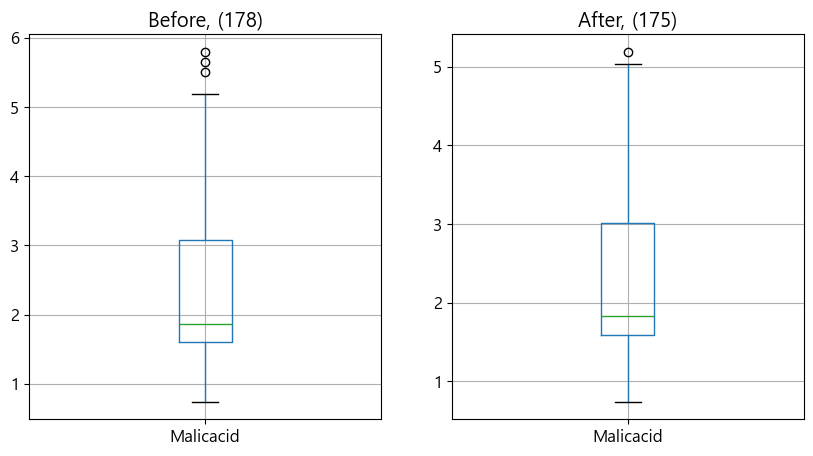

In [ ]:
# ----------------------------------------
# 절단(truncate) 방식 전/후 비교
# ----------------------------------------
df_prep1 = pd.DataFrame(wine.Malicacid.drop(out_ids, axis=0))

ShowBoxplot(wine[['Malicacid']], df_prep1)

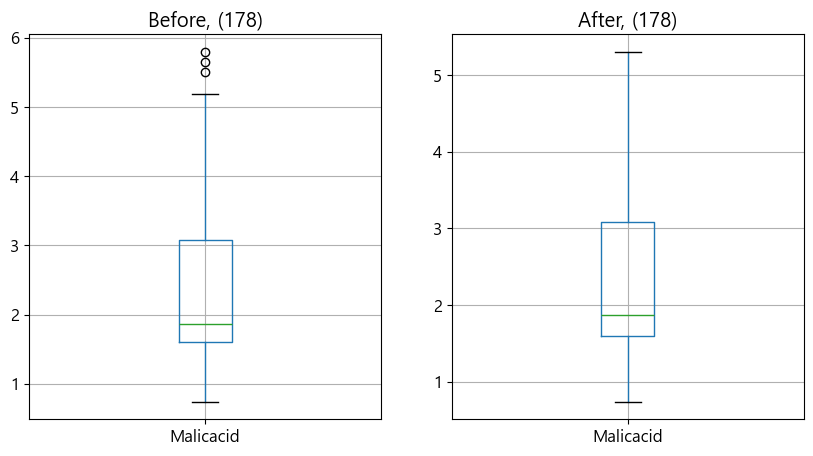

In [ ]:
# ----------------------------------------
# 조정(Winsorizing) 방식 전/후 비교
# ----------------------------------------
df_prep2 = wine[['Malicacid']].clip(top, down)

ShowBoxplot(wine[['Malicacid']], df_prep2)

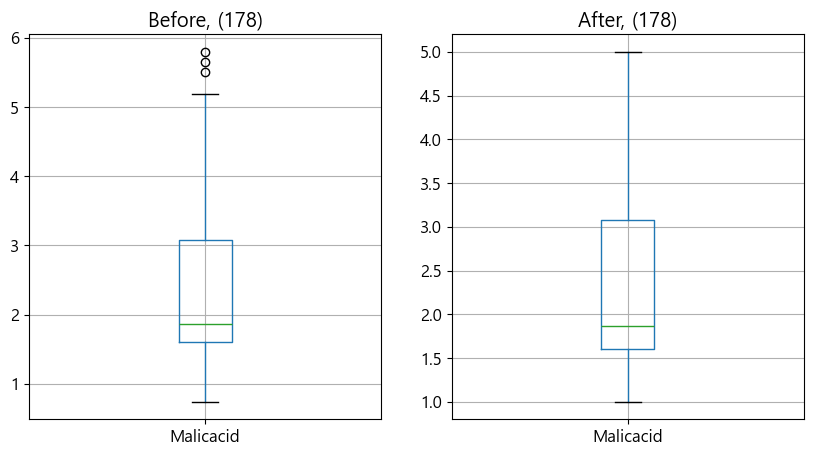

In [ ]:
# ----------------------------------------
# 클리핑(Clipping) 방식 전/후 비교
# ----------------------------------------
df_prep3 = wine[['Malicacid']].clip(5, 1)   # 함수는 동일하게 clip을 쓰는 값을 직접 지정

ShowBoxplot(wine[['Malicacid']], df_prep3)

### 클래스 불균형 처리하기

In [ ]:
from sklearn.datasets import load_breast_cancer
from pandas import concat
from collections import Counter
import seaborn as sns

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names).filter(['mean radius', 'mean texture', 'mean area', 'target'])
df['target'] = data.target

# 불균형한 imbdf 생성
df1 = df[df.target==0].sample(50)
df2 = df[df.target==1].sample(250)
imbdf = concat([df1, df2]).reset_index(drop=True)

features = imbdf.drop(['target'], axis=1)
target = imbdf.target

def CompareOverSampleMethod(imb_df, os_df):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title('imbalanced')
    sns.scatterplot(x='mean radius', y='mean texture', hue='target', alpha=0.5, style='target', data=imb_df, ax=ax[0], markers={0:'s', 1:'>'})
    ax[1].set_title('oversampled')
    sns.scatterplot(x='mean radius', y='mean texture', hue='target', alpha=0.5, style='target', data=os_df, ax=ax[1], markers={0:'s', 1:'>'})

0      0
1      0
2      0
3      0
4      0
      ..
295    1
296    1
297    1
298    1
299    1
Name: target, Length: 300, dtype: int64

0      0
1      0
2      0
3      0
4      0
      ..
295    1
296    1
297    1
298    1
299    1
Name: target, Length: 300, dtype: int64

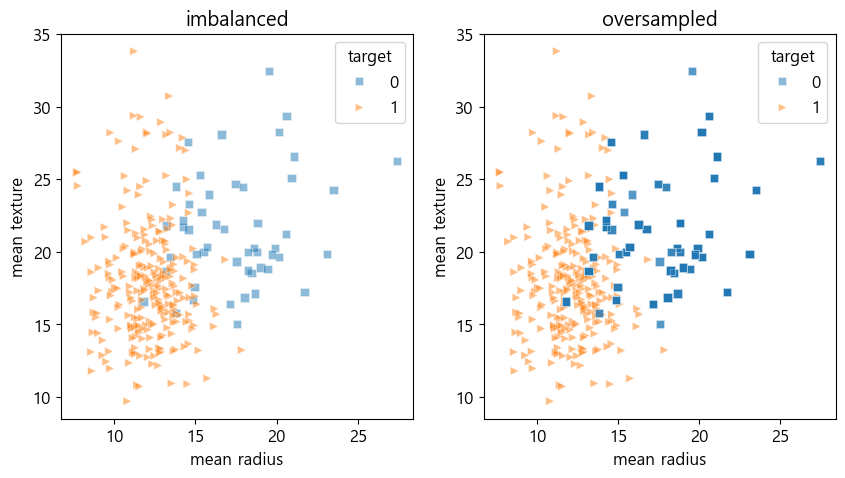

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(random_state=0)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df1 = concat([bal_feat, bal_targ], axis=1)

CompareOverSampleMethod(imbdf, over_df1)

In [65]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df2 = concat([bal_feat, bal_targ], axis=1)

from imblearn.over_sampling import BorderlineSMOTE

os = BorderlineSMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df3 = concat([bal_feat, bal_targ], axis=1)

from imblearn.over_sampling import KMeansSMOTE

os = KMeansSMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df4 = concat([bal_feat, bal_targ], axis=1)


from imblearn.over_sampling import SVMSMOTE

os = SVMSMOTE(random_state=0, k_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df5 = concat([bal_feat, bal_targ], axis=1)


from imblearn.over_sampling import ADASYN

os = ADASYN(random_state=0, n_neighbors=3)
bal_feat, bal_targ = os.fit_resample(features, target)
over_df6 = concat([bal_feat, bal_targ], axis=1)

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

data = [imbdf, over_df1, over_df2, over_df3 ,over_df4, over_df5, over_df6]
titles=['imbalanced', 'Random', 'SMOTE', 'BorderlineSMOTE', 'KMeansSMOTE', 'SVMSMOTE', 'ADASYN']

scores = pd.DataFrame(index=['train acc', 'test acc', 'train F1', 'test F1'], columns=titles)

for df, title in zip(data, titles):
    feats = df.drop('target', axis=1)
    target = df.target

    X_train, X_test, y_train, y_test = train_test_split(feats, target)

    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)

    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)

    scores.loc['train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['train f1', title] = f1_score(y_train, pred_train)
    scores.loc['test f1', title] = f1_score(y_test, pred_test)

print(scores)

          imbalanced    Random     SMOTE BorderlineSMOTE KMeansSMOTE  \
train acc   0.942222     0.896  0.893333           0.864    0.970667   
test acc        0.96      0.96     0.904           0.928    0.952381   
train F1         NaN       NaN       NaN             NaN         NaN   
test F1          NaN       NaN       NaN             NaN         NaN   
train f1    0.967089  0.897638  0.896907        0.866142    0.971576   
test f1     0.974359  0.958678       0.9        0.921739    0.951613   

           SVMSMOTE    ADASYN  
train acc  0.909333  0.824468  
test acc      0.896   0.81746  
train F1        NaN       NaN  
test F1         NaN       NaN  
train f1   0.909091  0.830769  
test f1    0.892562  0.813008  


### 변수 변환

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['axes.unicode_minus'] = False

diabetes = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/refs/heads/main/2-4_diabetes.csv');

X = diabetes.filter(['Pregnancies', 'BloodPressure', 'BMI', 'Age'])
y = diabetes['Outcome']

def test_scaling(X, scaled_X):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for col, a in zip(X.columns, [0.02, 0.1, 0.6, 1]):
        sns.kdeplot(X[col], alpha=a, legend=True, ax=ax[0], fill=True, color='r')
    ax[0].legend(X.columns)
    ax[0].set_xlabel('Features')
    ax[0].set_title('Before Scaling')

    for col, a in zip(scaled_X.columns, [0.02, 0.1, 0.6, 1]):
        sns.kdeplot(scaled_X[col], alpha=a, legend=True, ax=ax[1], fill=True, color='r')
    ax[1].legend(scaled_X.columns)
    ax[1].set_xlabel('Features')
    ax[1].set_title('Before Scaling')

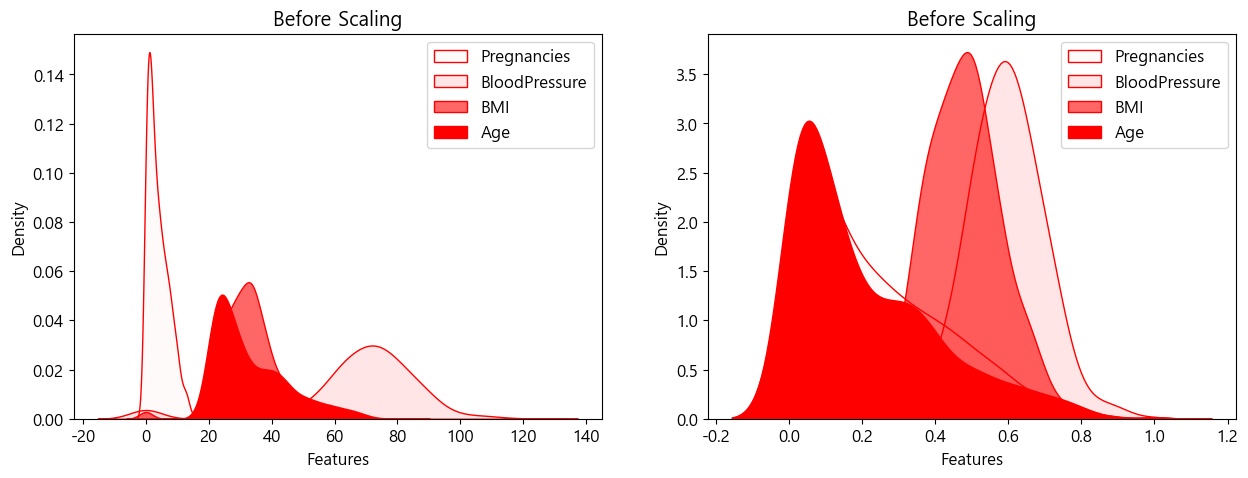

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
mm_X = scaler.fit_transform(X)
mm_X = pd.DataFrame(mm_X, columns=X.columns)
test_scaling(X, mm_X)

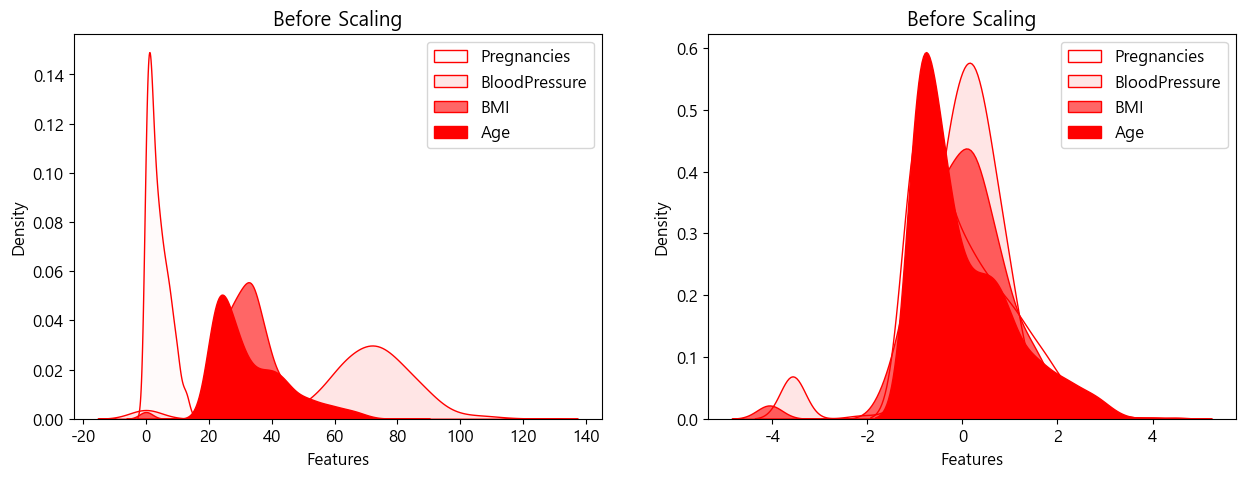

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ss_X = scaler.fit_transform(X)
ss_X = pd.DataFrame(ss_X, columns=X.columns)
test_scaling(X, ss_X)

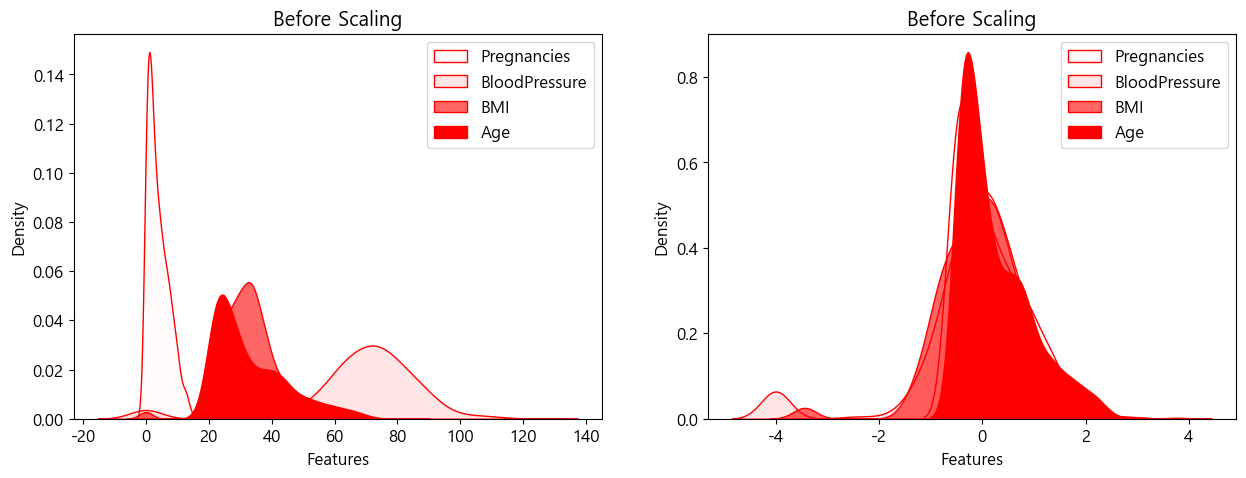

In [37]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
rs_X = scaler.fit_transform(X)
rs_X = pd.DataFrame(rs_X, columns=X.columns)
test_scaling(X, rs_X)

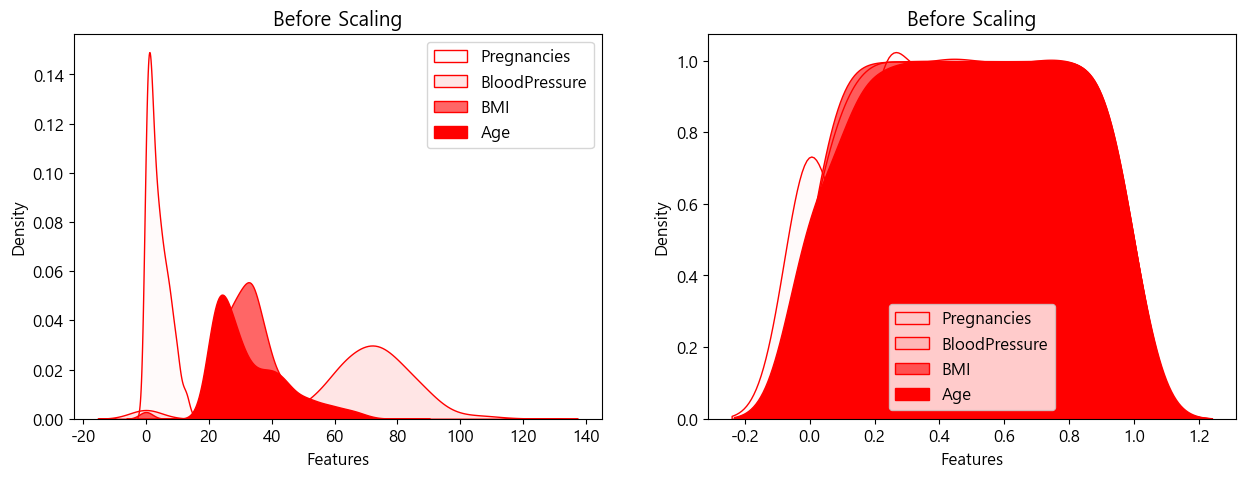

In [36]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='uniform', n_quantiles = len(X))
quu_X = scaler.fit_transform(X)
quu_X = pd.DataFrame(quu_X, columns=X.columns)
test_scaling(X, quu_X)

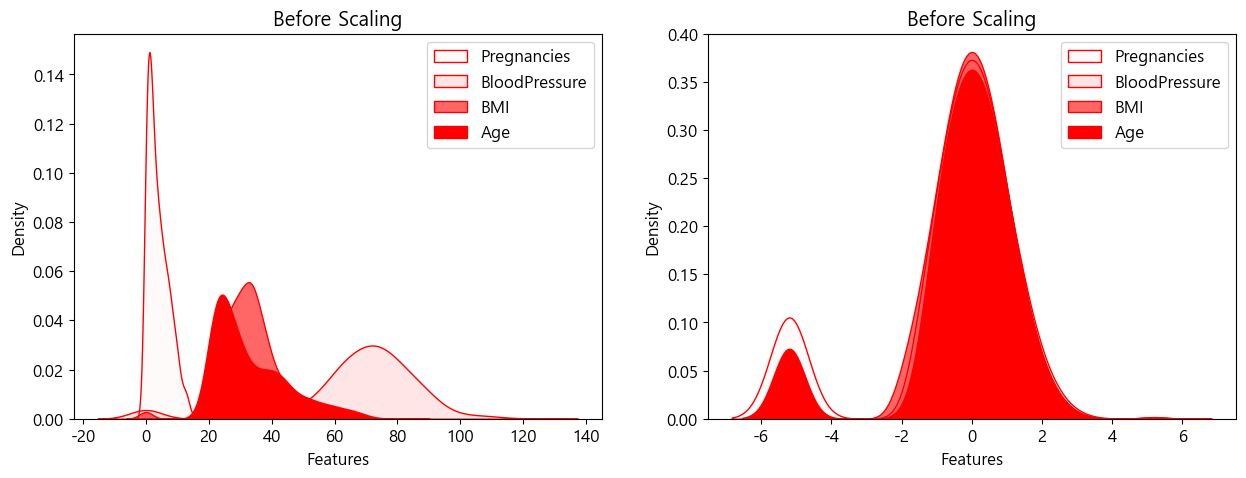

In [34]:
scaler = QuantileTransformer(output_distribution='normal', n_quantiles = len(X))
qun_X = scaler.fit_transform(X)
qun_X = pd.DataFrame(qun_X, columns=X.columns)
test_scaling(X, qun_X)


In [51]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

data = [X, mm_X, ss_X, rs_X, quu_X, qun_X]
titles= ['No-scaling', 'MinMax', 'Standard', 'Robust', 'QuntileT-uniform', 'QuantileT-normal']
y = diabetes.Outcome

scores = pd.DataFrame(index=['train acc', 'test acc', 'train F1', 'test F1'])
coeffs = pd.DataFrame(index=titles, columns=X.columns)

for df, title in zip(data, titles):
    X_train, X_test, y_train, y_test = train_test_split(df, y)
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)

    scores.loc['train acc', title] = accuracy_score(y_train,pred_train)
    scores.loc['test acc', title] = accuracy_score(y_test,pred_test)
    scores.loc['train F1', title] = f1_score(y_train, pred_train)
    scores.loc['test F1', title] = f1_score(y_test, pred_test)

    coeffs.loc[title, :] = lr.coef_

print(scores)


           No-scaling    MinMax  ...  QuntileT-uniform  QuantileT-normal
train acc    0.690972  0.671875  ...          0.704861          0.692708
test acc     0.703125  0.697917  ...          0.682292          0.656250
train F1     0.447205  0.367893  ...          0.505814          0.486957
test F1      0.495575  0.408163  ...          0.440367          0.352941

[4 rows x 6 columns]


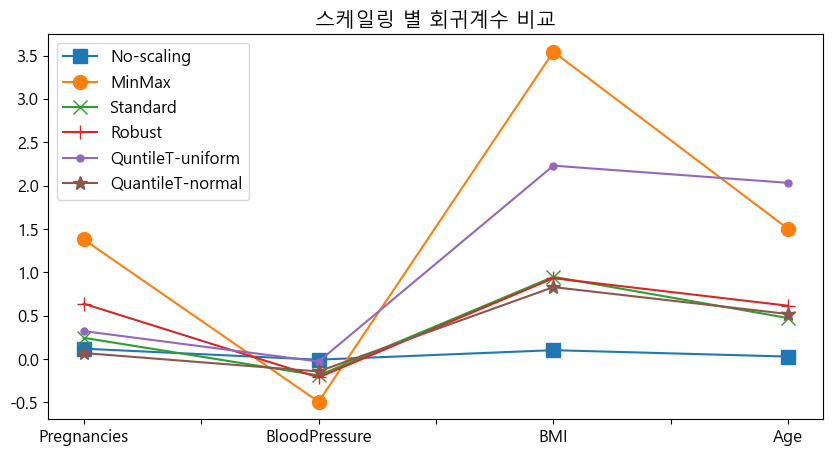

In [54]:
fig, ax = plt.subplots(1,1, figsize=(10 ,5))
ax.set_title('스케일링 별 회귀계수 비교')

for i, marker in enumerate(['s', 'o', 'x', '+', '.', '*']):
    coeffs.iloc[i, :].plot(ax=ax, marker=marker, ms=10)
ax.legend()

plt.show()

In [57]:
estate = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/refs/heads/main/2-4_BHP.csv")
X = estate[['bath', 'balcony']]
y = estate[['price']]

In [61]:
from sklearn.preprocessing import PowerTransformer

PTB = PowerTransformer(method='box-cox')
PTY = PowerTransformer(method='yeo-johnson')

y_ptb = pd.DataFrame(PTB.fit_transform(y), columns=y.columns)
y_pty = pd.DataFrame(PTY.fit_transform(y), columns=y.columns)

y_ptb[:1]

,price
0,-1.077895


['log10', 'log', 'boxcox']
['log10', 'log', 'boxcox']
['log10', 'log', 'boxcox']


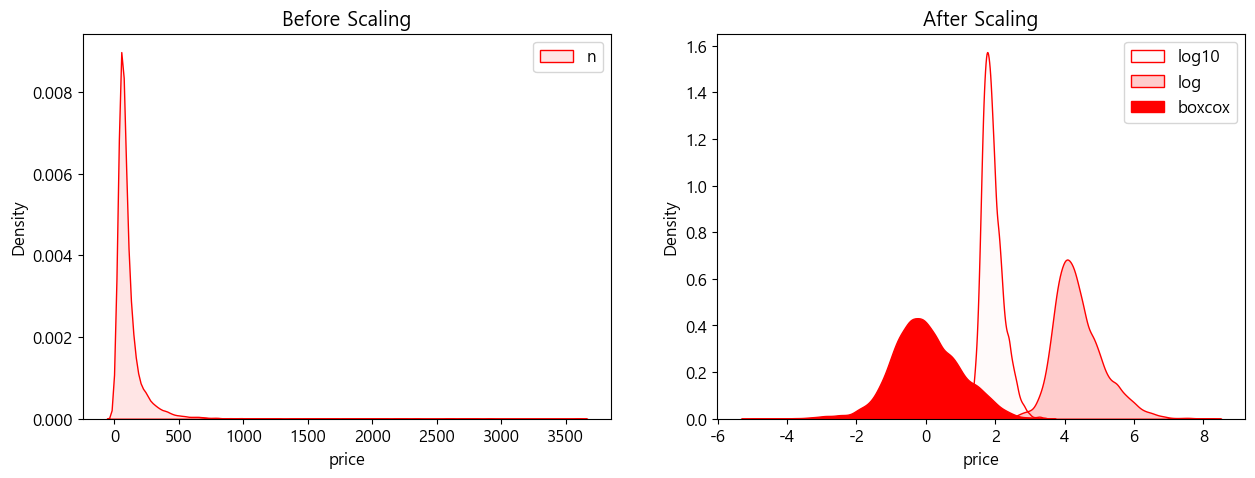

In [69]:
no_scale, log10, log, boxcox = y, np.log10(y), np.log(y), y_ptb

data =  [no_scale, log10, log, boxcox]
titles= ['no_scale', 'log10', 'log', 'boxcox']
alphas =[0.1, 0.02, 0.2, 1] 

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i, df, a, title in zip(range(len(data)), data, alphas, titles):
    if i==0:
        sns.kdeplot(df.price, ax=ax[0], alpha=a, fill=True, color='red')
        ax[0].legend(titles[0])
        ax[0].set_title('Before Scaling')
    else:
        sns.kdeplot(df.price, ax=ax[1], alpha=a, fill=True, color='red')
        print(titles[1:])
        ax[1].legend(titles[1:])
        ax[1].set_title('After Scaling')

plt.show()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['axes.unicode_minus'] = False

data = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/refs/heads/main/practice1_bank.csv')


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   month      4521 non-null   object
 10  y          4521 non-null   object
dtypes: int64(2), object(9)
memory usage: 388.6+ KB


<Axes: >

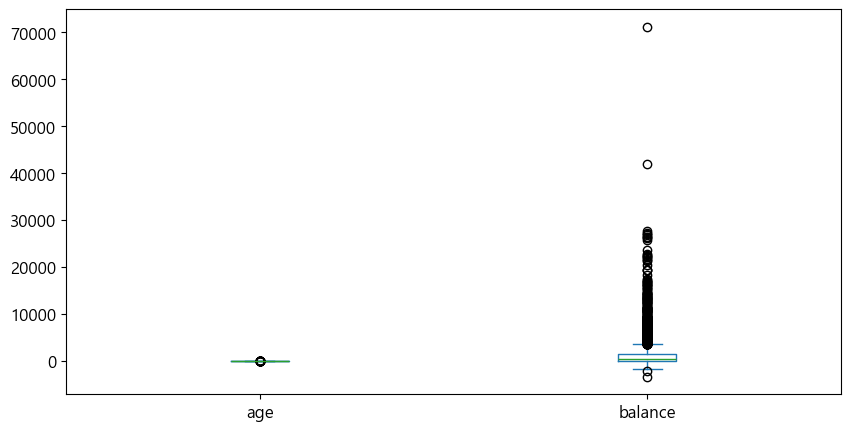

In [9]:
data[['age', 'balance']].plot(kind='box')

In [11]:
data.shape

(4521, 11)

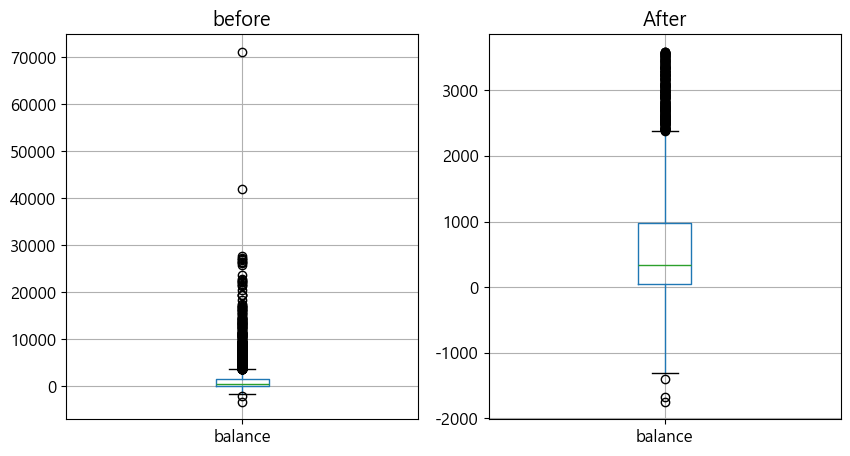

In [32]:
IQR = data.balance.quantile(0.75) - data.balance.quantile(0.25)
up_bound = data.balance.quantile(0.75) + IQR * 1.5
lo_bound = data.balance.quantile(0.25) - IQR * 1.5

outdb = data[(data.balance < up_bound) & (data.balance > lo_bound)]
outdb.shape
#outdb = data.copy()
#outdb.balance = data.balance.clip(up_bound, lo_bound)

fig, axes = plt.subplots(1, 2)
for df, title, ax in zip([data, outdb], ['before', 'After'], axes):
    df[['balance']].boxplot(ax=ax)
    ax.set_title(title)

In [67]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
oh = OneHotEncoder()

df = data.copy()

def show_uniq_vals(df):
    for col in df.columns:
        if df[col].dtype == 'O':
            print(df[col].value_counts())

enc_y = pd.get_dummies(df.y)

df['education_enc'] = le.fit_transform(df.education)
df.head(10)
print(le.classes_)


['primary' 'secondary' 'tertiary' 'unknown']


In [41]:
data.education.dtype

dtype('O')

In [98]:
# 나이는 구간 분할한다.
from sklearn.preprocessing import KBinsDiscretizer

kb = KBinsDiscretizer(n_bins = 10, strategy = 'quantile')
kb.fit(df[['age']])

kb_test = kb.transform(df[['age']])\

#print(kb.bin_edges_[0])

edges = kb.bin_edges_[0]
bins = []
for edge, i in zip(edges, range(len(edges))):
    if i < len(edges)-1 :
        bins.append((edges[i], edges[i+1]))
#print(bins)

kb_test = pd.DataFrame(kb_test.toarray(), columns=bins)
print(kb_test)


      (19.0, 29.0)  (29.0, 32.0)  (32.0, 34.0)  (34.0, 36.0)  (36.0, 39.0)  \
0              0.0           1.0           0.0           0.0           0.0   
1              0.0           0.0           1.0           0.0           0.0   
2              0.0           0.0           0.0           1.0           0.0   
3              0.0           1.0           0.0           0.0           0.0   
4              0.0           0.0           0.0           0.0           0.0   
...            ...           ...           ...           ...           ...   
4516           0.0           0.0           1.0           0.0           0.0   
4517           0.0           0.0           0.0           0.0           0.0   
4518           0.0           0.0           0.0           0.0           0.0   
4519           1.0           0.0           0.0           0.0           0.0   
4520           0.0           0.0           0.0           0.0           0.0   

      (39.0, 43.0)  (43.0, 47.0)  (47.0, 51.0)  (51.0, 56.0)  (

array([[<Axes: title={'center': 'balance_enc'}>]], dtype=object)

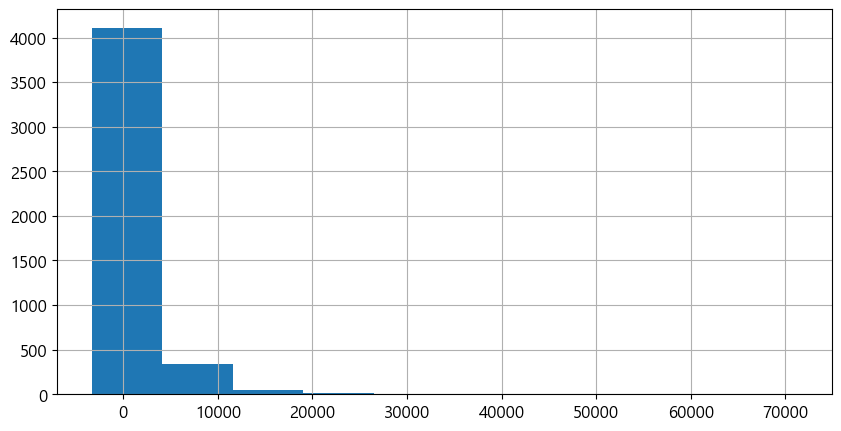

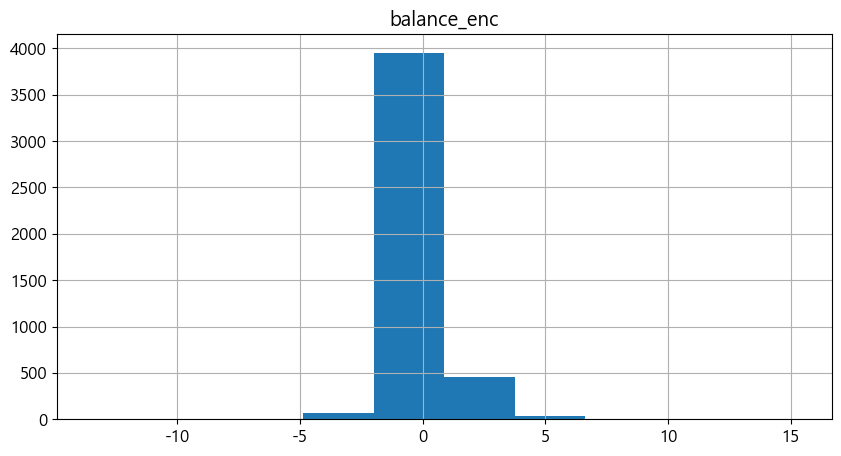

In [119]:
from sklearn.preprocessing import PowerTransformer

df.balance.hist()

pt = PowerTransformer(method='yeo-johnson')
test_pt = pd.DataFrame(pt.fit_transform(df[['balance']]), columns=['balance_enc'])
test_pt.hist()


In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '12'
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['axes.unicode_minus'] = False

from sklearn.datasets import load_iris

data = load_iris()
cols = data.feature_names + ['target']

iris= pd.DataFrame(np.c_[data.data, data.target], columns = [col.replace(' (cm)', '') for col in cols] )
iris

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [9]:
# 비복원 임의 추출
smp1 = iris.sample(n=3, replace=False)
print(smp1.head(3))

# 전체의 3% 추출
smp2 = iris.sample(frac=0.3)
print(smp2.head(3))

     sepal length  sepal width  petal length  petal width  target
69            5.6          2.5           3.9          1.1     1.0
45            4.8          3.0           1.4          0.3     0.0
105           7.6          3.0           6.6          2.1     2.0
    sepal length  sepal width  petal length  petal width  target
12           4.8          3.0           1.4          0.1     0.0
62           6.0          2.2           4.0          1.0     1.0
61           5.9          3.0           4.2          1.5     1.0


In [32]:
#---------------------------------------------
# 계통 추출법 (Systematic Sampling)
#---------------------------------------------
# 데이터의 순번에 필요한 샘플 수 만큼 구간을 만들고 각 구간에서 1개씩 임의 추출.
N = len(iris)   # 전체 데이터 수
n = 8           # 추출할 샘플 수
K = N / n       # 구간 데이터 수

smp = pd.DataFrame()

for index in range(N):
    if( index % 18 == 0 ):
        smp = smp._append(iris.loc[index,:], ignore_index=True)
        print(index)

print(f'N : {N}')
print(f'n : {n}')
print(f'K : {K}')

smp

0
18
36
54
72
90
108
126
144
N : 150
n : 8
K : 18.75


,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0.0
1,5.7,3.8,1.7,0.3,0.0
2,5.5,3.5,1.3,0.2,0.0
3,6.5,2.8,4.6,1.5,1.0
4,6.3,2.5,4.9,1.5,1.0
5,5.5,2.6,4.4,1.2,1.0
6,6.7,2.5,5.8,1.8,2.0
7,6.2,2.8,4.8,1.8,2.0
8,6.7,3.3,5.7,2.5,2.0


In [ ]:
#---------------------------------------------
# 집락 추출법 (Cluster Random Sampling)
#---------------------------------------------
# 먼저 군집을 나눈다. 이를테면 성별로 나누거나 지역별로 나누고, 그 안에서 Random Sampling한다.  
# 지역표본추출이 이에 해당한다.

In [58]:
#---------------------------------------------
# 계통 추출법 (Stratified Random Sampling)
#---------------------------------------------
# 중요한 feature의 각 고유값 별로 균등하게 샘플링한다.
vals = iris.target.unique()

stratum = 'target'
n = 9               # 추출할 샘플 수 
K = 9 / len(vals)   #각 stratum 내 샘플 수 

smp = pd.DataFrame()
for i in vals:
    print(i)
    smp = pd.concat( [smp, iris[iris.target==i].sample(n=int(K))] )

print(smp)

0.0
1.0
2.0
     sepal length  sepal width  petal length  petal width  target
9             4.9          3.1           1.5          0.1     0.0
44            5.1          3.8           1.9          0.4     0.0
8             4.4          2.9           1.4          0.2     0.0
94            5.6          2.7           4.2          1.3     1.0
77            6.7          3.0           5.0          1.7     1.0
89            5.5          2.5           4.0          1.3     1.0
108           6.7          2.5           5.8          1.8     2.0
124           6.7          3.3           5.7          2.1     2.0
100           6.3          3.3           6.0          2.5     2.0


In [79]:
X = iris.drop('target', axis=1)
y = iris.target

def ShowComposition(X_train, X_test, y_train, y_test):
    print('X_train:X_test (%d:%d)    y_train:y_test (%d:%d)' %(len(X_train), len(X_test), len(y_train), len(y_test)))
    print('X_train ratio : %.2f   X_test ration : %.2f' %(len(X_train)/len(iris), len(X_test)/len(iris)))

def ShowResult(X, y, train_index, test_index):
    print(f'split {i} ==> train_index ={train_index[:3]}  test_index = {test_index[:3]}')
    X_train, X_test, y_train, y_test = X.iloc[train_index,:], X.iloc[test_index,:], y.iloc[train_index], y.iloc[test_index]
    print('X_train ratio : %.2f   X_test ration : %.2f' %(len(X_train)/len(iris), len(X_test)/len(iris)))
    print('y_train 타겟 구성', Counter(y_train))
    print('y_test 타겟 구성', Counter(y_test), '\n')


In [ ]:
#---------------------------------------------
# 일반적 데이터 분할 (Hold-out은 50:50)
#---------------------------------------------
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
ShowComposition(X_train, X_test, y_train, y_test)


X_train:X_test (75:75)    y_train:y_test (75:75)
X_train ratio : 0.50   X_test ration : 0.50


In [ ]:
#---------------------------------------------
# Shuffle Split (Random permutation cross-validator)
#---------------------------------------------

from sklearn.model_selection import ShuffleSplit
from collections import Counter
ss = ShuffleSplit(test_size=0.5, train_size=0.5, n_splits=4)

for i, (train_index, test_index) in enumerate(ss.split(X)):
    ShowResult(X, y, train_index, test_index)


split 0 ==> train_index =[61 48 25]  test_index = [102   4 147]
X_train ratio : 0.50   X_test ration : 0.50
y_train 타겟 구성 Counter({1.0: 28, 2.0: 27, 0.0: 20})
y_test 타겟 구성 Counter({0.0: 30, 2.0: 23, 1.0: 22}) 

split 1 ==> train_index =[ 92 124  81]  test_index = [ 55 145 108]
X_train ratio : 0.50   X_test ration : 0.50
y_train 타겟 구성 Counter({1.0: 27, 2.0: 25, 0.0: 23})
y_test 타겟 구성 Counter({0.0: 27, 2.0: 25, 1.0: 23}) 

split 2 ==> train_index =[53 39 78]  test_index = [143  56  54]
X_train ratio : 0.50   X_test ration : 0.50
y_train 타겟 구성 Counter({1.0: 30, 0.0: 23, 2.0: 22})
y_test 타겟 구성 Counter({2.0: 28, 0.0: 27, 1.0: 20}) 

split 3 ==> train_index =[124  42  56]  test_index = [ 83  35 119]
X_train ratio : 0.50   X_test ration : 0.50
y_train 타겟 구성 Counter({1.0: 28, 2.0: 26, 0.0: 21})
y_test 타겟 구성 Counter({0.0: 29, 2.0: 24, 1.0: 22}) 



In [81]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=False)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    ShowResult(X, y, train_index, test_index)

split 0 ==> train_index =[38 39 40]  test_index = [0 1 2]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({1.0: 50, 2.0: 50, 0.0: 12})
y_test 타겟 구성 Counter({0.0: 38}) 

split 1 ==> train_index =[0 1 2]  test_index = [38 39 40]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({2.0: 50, 0.0: 38, 1.0: 24})
y_test 타겟 구성 Counter({1.0: 26, 0.0: 12}) 

split 2 ==> train_index =[0 1 2]  test_index = [76 77 78]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({0.0: 50, 2.0: 37, 1.0: 26})
y_test 타겟 구성 Counter({1.0: 24, 2.0: 13}) 

split 3 ==> train_index =[0 1 2]  test_index = [113 114 115]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({0.0: 50, 1.0: 50, 2.0: 13})
y_test 타겟 구성 Counter({2.0: 37}) 



In [ ]:
from sklearn.model_selection import StratifiedKFold

stkf = StratifiedKFold(n_splits=4, shuffle=False)

for i, (train_index, test_index) in enumerate(stkf.split(X, y)):
    ShowResult(X, y, train_index, test_index)

split 0 ==> train_index =[13 14 15]  test_index = [0 1 2]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({1.0: 38, 0.0: 37, 2.0: 37})
y_test 타겟 구성 Counter({0.0: 13, 2.0: 13, 1.0: 12}) 

split 1 ==> train_index =[0 1 2]  test_index = [13 14 15]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({1.0: 38, 0.0: 37, 2.0: 37})
y_test 타겟 구성 Counter({0.0: 13, 2.0: 13, 1.0: 12}) 

split 2 ==> train_index =[0 1 2]  test_index = [26 27 28]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({0.0: 38, 2.0: 38, 1.0: 37})
y_test 타겟 구성 Counter({1.0: 13, 0.0: 12, 2.0: 12}) 

split 3 ==> train_index =[0 1 2]  test_index = [38 39 40]
X_train ratio : 0.75   X_test ration : 0.25
y_train 타겟 구성 Counter({0.0: 38, 2.0: 38, 1.0: 37})
y_test 타겟 구성 Counter({1.0: 13, 0.0: 12, 2.0: 12}) 



In [85]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression

X = iris.drop('target', axis=1)
y = iris.target

stkf = StratifiedKFold(n_splits=4)
model = LogisticRegression(max_iter=1000, C=0.01)

result = cross_validate(model, X, y, cv=stkf, return_train_score=True)
print(pd.DataFrame(result))

   fit_time  score_time  test_score  train_score
0  0.019787    0.002000    0.815789     0.892857
1  0.009308    0.002000    0.894737     0.866071
2  0.009016    0.001517    0.783784     0.876106
3  0.007644    0.001864    0.945946     0.831858


In [87]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression

X = iris.drop('target', axis=1)
y = iris.target

param_grid = {'C':[0.01, 0.02, 0.1, 0.2], 'solver':['lbfgs', 'liblinear']}
stkf = StratifiedKFold(n_splits=4, shuffle=False)
model = LogisticRegression(max_iter=2000)

grid = GridSearchCV(model, param_grid=param_grid, cv=stkf)
grid.fit(X, y)

print(grid.best_score_)
print(grid.best_params_)

0.9534139402560455
{'C': 0.2, 'solver': 'lbfgs'}


In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/refs/heads/main/practice1_bank.csv')


le = LabelEncoder()
data_en = pd.DataFrame()

for col in data.columns:
    if data[col].dtype == object:
        data_en[col] = le.fit_transform(data[col])
    else:
        data_en[col] = data[col]

X = data_en.drop('y', axis=1)
y = data_en.y

model = RandomForestClassifier(n_estimators=100)
params = {'max_depth':[4, 6, 8]}
stkf = StratifiedKFold(n_splits=4, shuffle=False)
grid = GridSearchCV(model, param_grid=params, cv=stkf)

grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 4}
0.884981181975384


In [ ]:

        
data_en

,age,job,marital,education,default,balance,housing,loan,contact,month,y
0,30,10,1,0,0,1787,0,0,0,10,0
1,33,7,1,1,0,4789,1,1,0,8,0
2,35,4,2,2,0,1350,1,0,0,0,0
3,30,4,1,2,0,1476,1,1,2,6,0
4,59,1,1,1,0,0,1,0,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...
4516,33,7,1,1,0,-333,1,0,0,5,0
4517,57,6,1,2,1,-3313,1,1,2,8,0
4518,57,9,1,1,0,295,0,0,0,1,0
4519,28,1,1,1,0,1137,0,0,0,3,0
